# Supplementary Figure 2: Analysis of multiple simulations

The distribution of posterior mean hail and reporting functions estimated from 100 simulations of synthetic data. The true probability is indicated by the dotted lines in each figure and 50% and 95% credible intervals are also shown as more and less opaque shaded regions respectively.

## Package imports

In [1]:
additional_package_lib <- "/scratch/w42/ig1052/rlibs"

suppressPackageStartupMessages({
  library(tidyverse)
  library(patchwork)
  library(scico)
  library(latex2exp, lib.loc = additional_package_lib)
})

## Utility functions

In [2]:
# inverse logit
inv_logit <- function(x){
  # The inverse logit or sigmoid function, used often in calculating probabilities
  #
  # Inputs:
  #  x  numeric, can be a vector
  #
  # Outputs:
  #  _  same shape as input, will be in (0, 1)

  1 / (1 + exp(-x))
}

In [3]:
# parameters for the confidence intervals used in severe places
inner_ci <- 0.5
outer_ci <- 0.95

get_tibble_to_plot <- function(model_name, var){
  # Convert the results for a given model name and variable into a tibble
  # amenable to plotting
  #
  # Inputs:
  #  model_name  str
  #              string indicating the name of the model in question 
  #              use the form employed in the file naming
  #  var         str
  #              one of hail or report for the appropriate function
  #
  # Outputs:
  #  _           tibble
  #              columns ready to be plotting with confidence bounds and 
  #              posterior mean 
    
  overall_name <- paste(ifelse(str_detect(model_name, "lhhr"), "lhhr", "hhlr"), 
                        "res", 
                        ifelse(str_detect(model_name, "cv"), "cv", "all"), 
                        sep = "_")
  extracting_column <- map(bulk_res, 
                           # for each bulk sim grab the lhhr results corresponding to the 
                           # right sim data set and cv/all regime and then select results 
                           # for the appropriate model
                           \(x) pluck(x, overall_name, model_name) %>% 
                           # and then select the columns with the posterior mean 
                           select(all_of(paste(model_name, var, "mean", sep = "_")))
                           )
  # bind each one column tibble (with identical names - ignore the warning)
  x_matrix <- if (var == "hail") x_mesh_matrix else x_log_pop_dens_matrix   
  # note x_mesh is untransformed
  x_trans <- if (var == "hail") x_matrix[, 2] else exp(x_matrix[, 2])
  # selecting true beta values
  beta_true <- params_list[[paste(ifelse(str_detect(model_name, "lhhr"), "lhhr", "hhlr"), "beta", var, sep = "_")]]
    
  suppressMessages(
    list_cbind(extracting_column, name_repair = "unique")
  ) %>%
    # make the data frame rowwise
    rowwise() %>%
    # get the bulk mean of the posterior mean, and the quantiles for plotting
    summarise(bulk_mean = mean(c_across(everything())),
              bulk_inner_lower = quantile(c_across(everything()), (1 - inner_ci) / 2),
              bulk_inner_upper = quantile(c_across(everything()), (1 + inner_ci) / 2),
              bulk_outer_lower = quantile(c_across(everything()), (1 - outer_ci) / 2),
              bulk_outer_upper = quantile(c_across(everything()), (1 + outer_ci) / 2)
              ) %>%
    add_column(true = inv_logit(x_matrix %*% beta_true),
               x = x_trans)
}

Note that this function for a single plot includes options for simulations which were not included in the final paper.

In [4]:
make_single_plot <- function(model_name, var){
  # Make a single plot of the simulation results for a given model
  # and variable 
  #
  # Inputs:
  #  model_name  str
  #              string indicating the name of the model in question 
  #              use the form employed in the file naming
  #  var         str
  #              one of hail or report for the appropriate function
  #
  # Outputs:
  #  _           ggplot object 
  #              plot to be included in the larger figure giving the true
  #              and simulated functions

  # axis labels
  x_lab <- ifelse(var == "hail", "MESH [mm]", TeX("Population Density [people km$^{-2}$]"))
  y_lab <- ifelse(var == "hail", "Posterior mean P(Hail = 1| MESH)", "Posterior mean P(Report = 1| Hail = 1, Pop. dens.)")
  # if standardised or not
  standardised <- ifelse(str_detect(model_name, "std"), "Standardised", "Unstandardised")

  # what the priors are 
  priors <- case_when(str_detect(model_name, "uninformative_gamma") ~ "weakly informative gamma",
                      str_detect(model_name, "uninformative") ~ "weakly informative",
                      str_detect(model_name, "misinformative") ~ "misleading",
                      str_detect(model_name, "naive") ~ "naïve",
                      str_detect(model_name, "small") ~ "shrinking",
                      str_detect(model_name, "gamma") ~ "standard normal and gamma",
                      str_detect(model_name, "informative") ~ "strongly informative",
                      TRUE ~ "standard normal")
  exp_number <- case_when(str_detect(model_name, "uninformative_gamma") ~ "(4)",
                          str_detect(model_name, "uninformative") ~ "(3)",
                          str_detect(model_name, "misinformative") ~ "(5)",
                          str_detect(model_name, "naive") ~ "(1)",
                          str_detect(model_name, "small") ~ "(7)",
                          str_detect(model_name, "gamma") ~ "(8)",
                          str_detect(model_name, "informative") ~ "(2)",
                          TRUE ~ "(6)")
  # putting all together into title
  title <- paste(exp_number, paste0(standardised, ","), priors, "priors")

  # opposinng model
  opposing_model_name <- ifelse(str_detect(model_name, "lhhr"), 
                                str_replace(model_name, "lhhr", "hhlr"), 
                                str_replace(model_name, "hhlr", "lhhr"))

  # confidence bounds 
  label_inner <- paste(inner_ci * 100, "%", sep = "")
  label_outer <- paste(outer_ci * 100, "%", sep = "")

  p <- bind_rows(list(LHHR = get_tibble_to_plot(model_name, var), 
                      HHLR = get_tibble_to_plot(opposing_model_name, var)),
                 .id = "regime") %>%
    ggplot(aes(x = x)) +
    geom_line(aes(y = bulk_mean, color = regime)) + 
    geom_line(aes(y = true, group = regime), linetype = "dotdash", color = "black") +
    # outer confidence bounds
    geom_ribbon(aes(ymin = bulk_outer_lower, ymax = bulk_outer_upper, fill = regime), alpha = 0.3) + 
    # inner confidence bounds 
    geom_ribbon(aes(ymin = bulk_inner_lower, ymax = bulk_inner_upper, fill = regime), alpha = 0.5) +
    xlab(x_lab) + 
    ylab(y_lab) +
    ggtitle(title) +
    labs(fill = "Regime", color = "Regime") +
    theme_gray(base_size = 18) +
    theme(plot.title = element_text(size = 16))

  if (var == "report") {
    p + 
      scale_x_log10()
  } else {
    p
  }
}

## Reading in and preparing data

In [5]:
# reading in results from location given by args[2] in the bulk_sims script
sims_res_dir <- "/g/data/w42/ig1052/bayesian_paper_data/bulk_sims/results"

# number of simulations given by args[3] in the bulk_sims script
bulk_res <- map(1:100, 
                \(x) readRDS(paste0(sims_res_dir, "/bulk_sims_res_", x, ".rds"))
               )

In [6]:
# creating matrices for evaluating and plotting etc. 
x_mesh_matrix <- readRDS(
  paste(sims_res_dir, "x_mesh_matrix.rds", sep = "/")
)
x_log_pop_dens_matrix <- readRDS(
  paste(sims_res_dir, "x_log_pop_dens_matrix.rds", sep = "/")
)

# defining the true parameters 
params_list <- list("lhhr_beta_hail" = c(-7, 0.0932),
                    "lhhr_beta_report" = c(-2, 1),
                    "hhlr_beta_hail" = c(-8, 0.3),
                    "hhlr_beta_report" = c(-4.258, 0.5))


## Making the plot

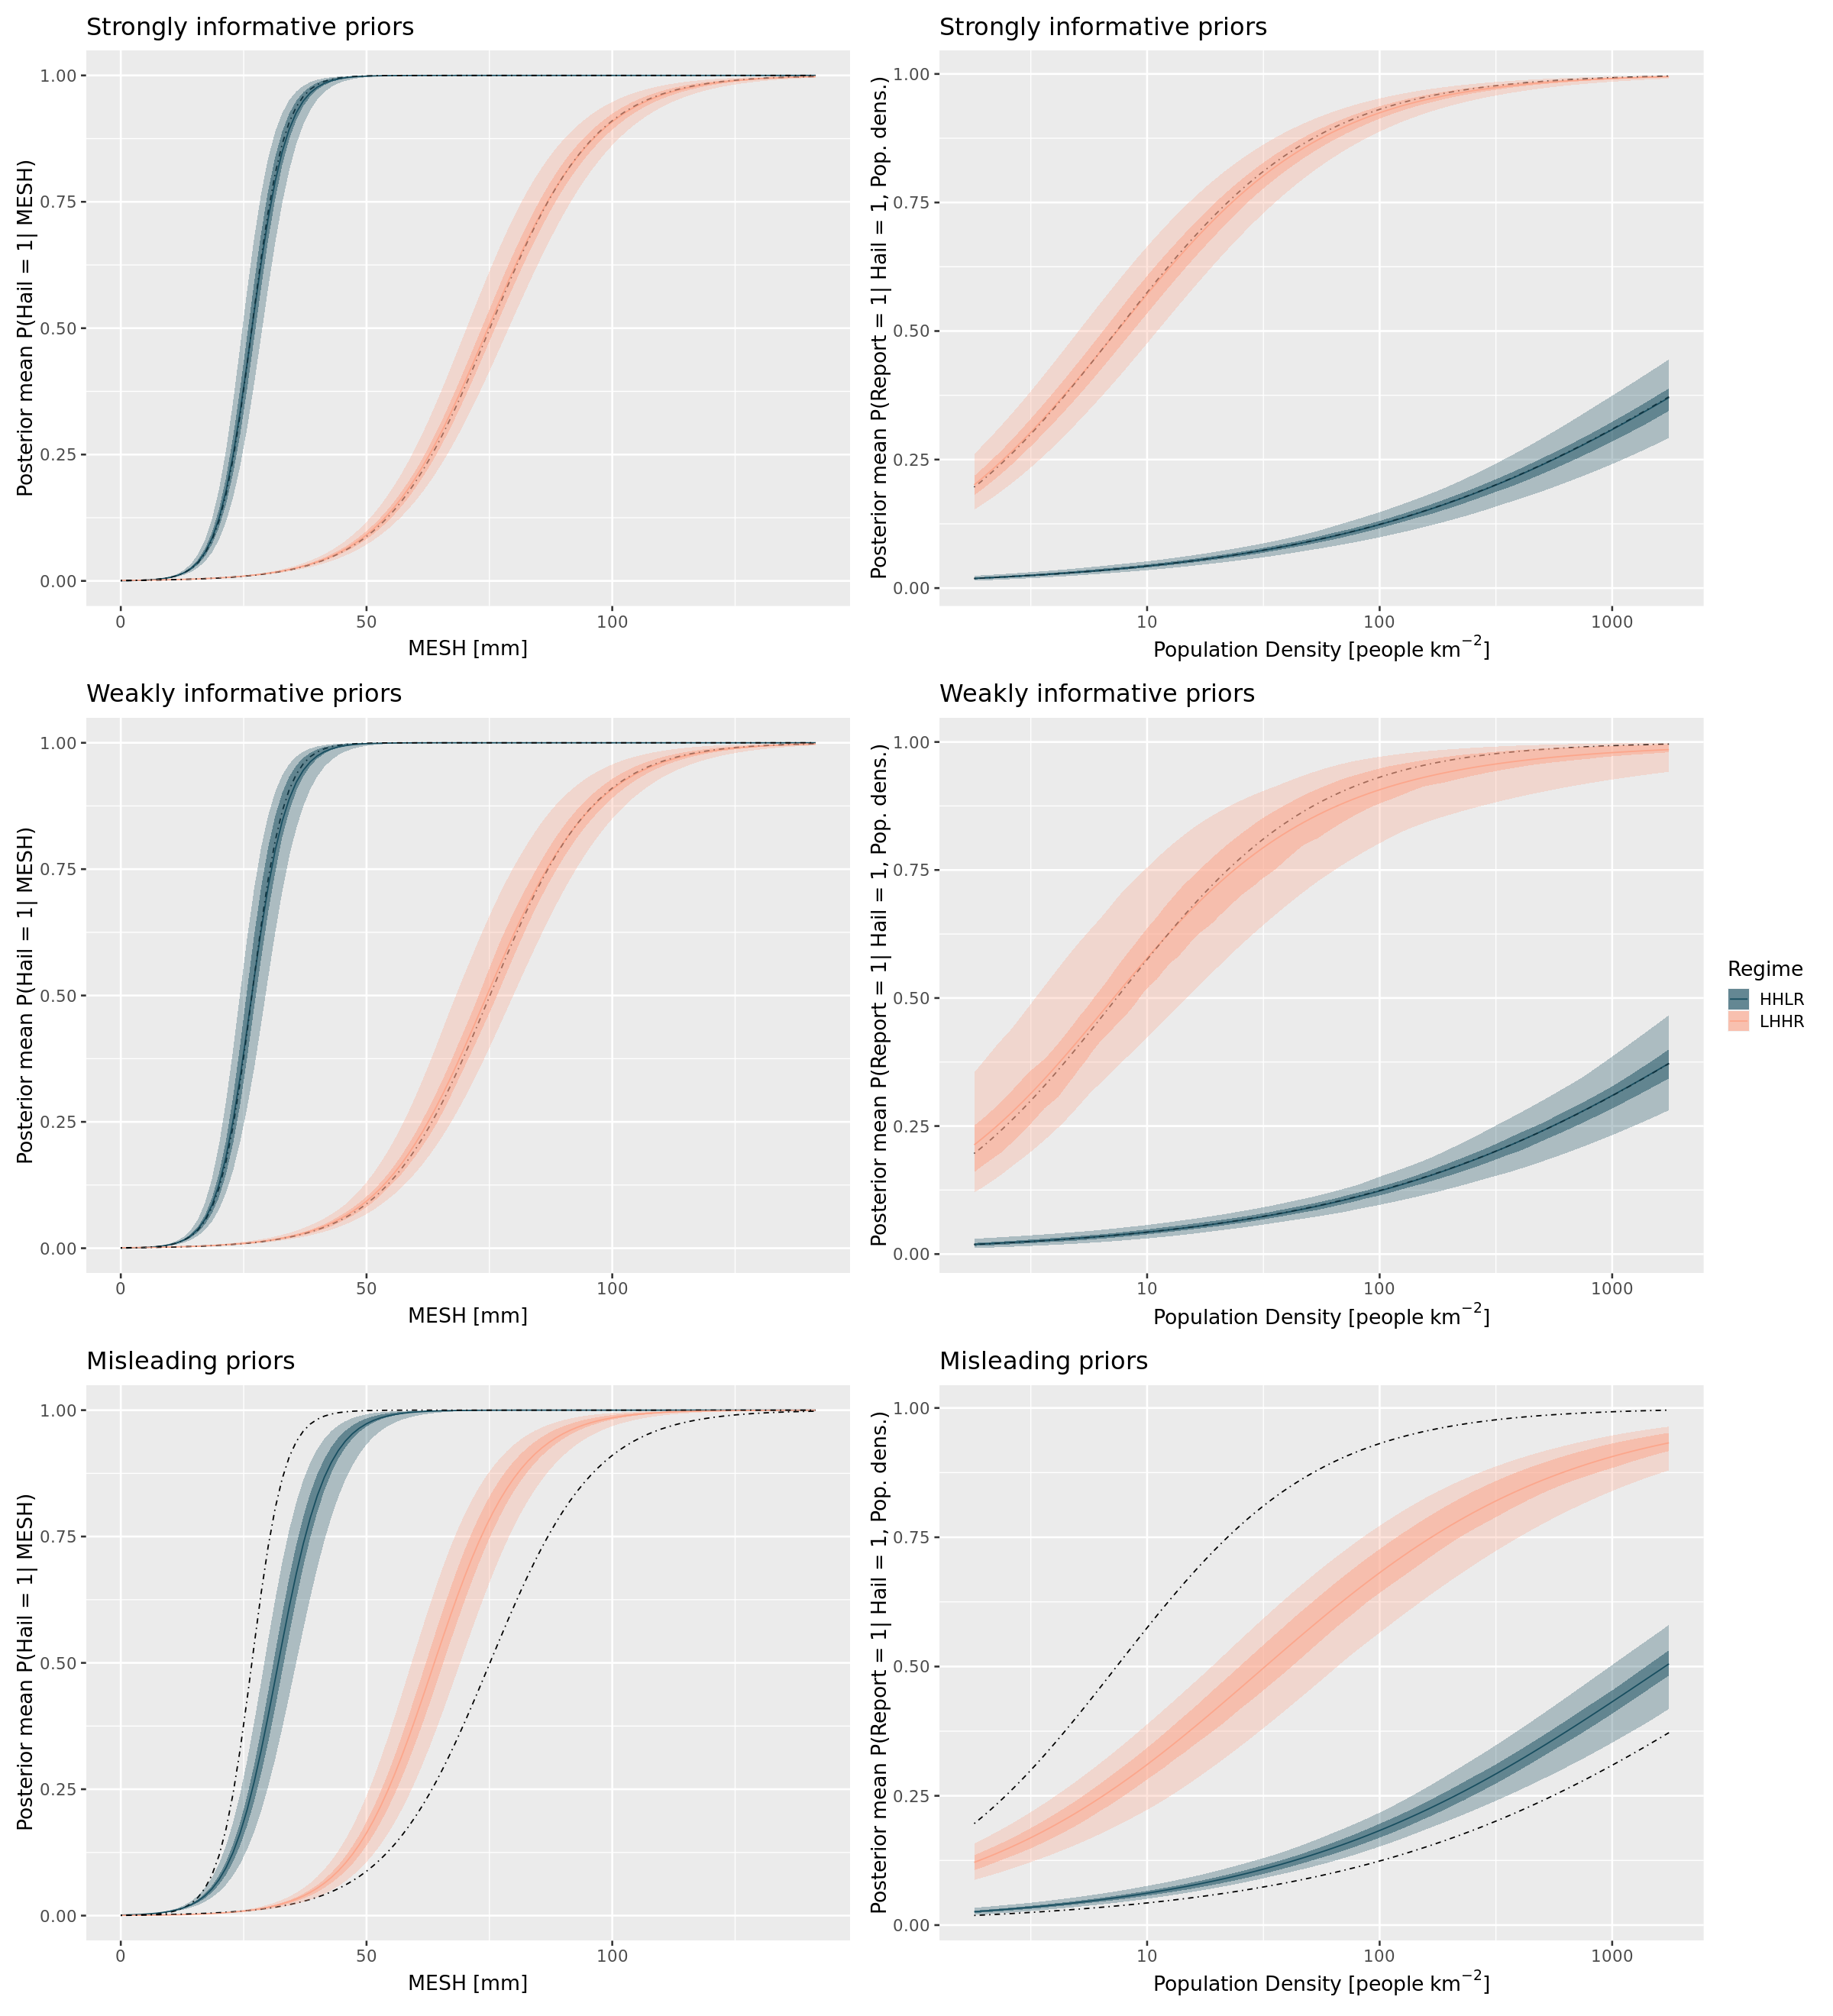

In [7]:
options(repr.plot.width = 20, repr.plot.height = 22)

# colour params
palette <- "batlow"
begin <- 0.2
end <- 0.8
base_size <- 16

# model names we're interested in
model_names <- c("sim_hail_mesh_report_dens_lhhr_informative_all", 
                 "sim_hail_mesh_report_dens_lhhr_uninformative_all", 
                 "sim_hail_mesh_report_dens_lhhr_misinformative_all")
# corresponding titles
plot_titles <- c("Strongly informative priors", "Weakly informative priors", "Misleading priors")

# creating the hail plots
plot_list_hail <- map2(model_names, 
                       plot_titles, 
                       \(x, y) make_single_plot(x, "hail") + 
                         ggtitle(y) +                                                       # update title
                         theme_gray(base_size = base_size) +                                # update size
                         scale_color_scico_d(palette = palette, begin = begin, end = end) + # scico colours
                         scale_fill_scico_d(palette = palette, begin = begin, end = end)    # scico fill
                      ) 

# creating hte report plots
plot_list_report <- map2(model_names, 
                       plot_titles, 
                       \(x, y) make_single_plot(x, "report") + 
                         ggtitle(y) +                                                       # update title
                         theme_gray(base_size = base_size) +                                # update size
                         scale_color_scico_d(palette = palette, begin = begin, end = end) + # scico colours
                         scale_fill_scico_d(palette = palette, begin = begin, end = end)    # scico fill
                      )

# wraps plots into one figure and collects legends 
c(plot_list_hail, plot_list_report) %>%
    wrap_plots(guides = "collect", nrow = 3, byrow = FALSE)